In [1]:
!pip install datasets lm_eval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 61.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 102.4 MB/s eta 0:00:0000:01
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=96acf3b51694ca45b9af8657e6995391edcdb7a004446295925e390e0ef8cfad
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
  Created wheel for sqlitedict: filename=sqlited

In [2]:
# importing the required libraries
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer, default_data_collator, Trainer, TrainingArguments
from collections import OrderedDict
from typing import List, Optional
import numpy as np
from tqdm.notebook import tqdm
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from lm_eval import evaluator, tasks

In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [4]:
def layer_removal(
    model: nn.Module,
    layers_to_remove: OrderedDict
):
    """
    Generic removal implementation
    """

    for layer_name, layer_idx in layers_to_remove.items():
        modules = layer_name.split(".")
        mod = model
        for m in modules[:-1]:
            mod = getattr(mod, m)
        
        if layer_idx is None:
            delattr(mod, modules[-1])
        else:
            delattr(mod, modules[-1])[layer_idx]

In [5]:
def block_influence(
    input_hidden_state: torch.Tensor,
    output_hidden_state: torch.Tensor,
    angular=False,
):
    """
    input_hidden_state: B, S, D
    output_hidden_state: B, S, D
    """
    _, _, d = input_hidden_state.shape
    input_hidden_state = input_hidden_state.reshape(-1, d)
    output_hidden_state = output_hidden_state.reshape(-1, d)

    norm_input = input_hidden_state.norm(dim=-1, keepdim=True)
    norm_output = output_hidden_state.norm(dim=-1, keepdim=True)

    sim = (input_hidden_state @ output_hidden_state.T) / (norm_input * norm_output)
    sim = sim.diagonal().nan_to_num(nan=0.5)

    if angular:
        return (torch.arccos(sim) / torch.pi)

    return 1 - sim

In [6]:
class ShortHFModel():

    def __init__(self, model_name: str, layers_path: str, n_prune_layers: Optional[int] = None):
        """
        HuggingFace Model Wrapper

        Args:
            model_name (str): HuggingFace model name
            layers_path (str): String in dot notation demonstrating how to access layers of the model. Ex: "model.layers"
            (Optional) n_prune_layers (int): Number of layers to prune. Defaults to None.
        """
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16)
        # self.model.params = self.model.to_fp16(self.model.params)
        self.model.to("cuda")

        modules = layers_path.split(".")
        mod = self.model
        for m in modules:
            mod = getattr(mod, m)
        self.layers = mod

        self.n_prune_layers = n_prune_layers
        self.importances = [0 for _ in self.layers]  # layer-wise importance scores

    def remove_layers(
        self,
        layers_to_remove: Optional[List[int]] = [],
        angular: Optional[bool] = False
    ):
        if angular:
            assert self.importances, "Need to compute importances with eval_importance()"
            assert self.n_prune_layers, "Need number of layers to prune, set `n_prune_layers`"
            start_layer = np.argsort(np.array(self.importances[:-self.n_prune_layers+1]))[0]
            layers_to_remove = list(range(start_layer, start_layer + self.n_prune_layers))
        elif not layers_to_remove and self.n_prune_layers:
            assert self.importances, "Need to compute importances with eval_importance()"
            layers_to_remove = np.argsort(np.array(self.importances))[:self.n_prune_layers].tolist()

        # remove layers in reverse to avoid indexing errors
        for layer_idx in sorted(layers_to_remove, reverse=True):
            try:
                del self.layers[layer_idx]
            except IndexError:
                print(f"layer {layer_idx} does not exist, function may have already been called")
                return []
        
        return layers_to_remove
    
    def compute_bi(self, hiddens: List[torch.Tensor], angular: bool):
        n = 1
        if angular:
            assert self.n_prune_layers is not None, "Set number of layers to prune to use angular importance"
            n = self.n_prune_layers

        for i in range(len(hiddens) - n):
            in_hidden = hiddens[i]
            out_hidden = hiddens[i+n]
            if angular:
                # use only last token for angular distance as described in section 3.2
                # https://arxiv.org/pdf/2403.17887.pdf
                in_hidden = in_hidden[:,-1:]
                out_hidden = out_hidden[:,-1:]
            
            self.importances[i] += block_influence(
                in_hidden,
                out_hidden,
                angular=angular
            ).sum().cpu().item()

    @torch.inference_mode()
    def eval_importance(
        self,
        prompts: List[str],
        max_seq_len: int,
        stride: int = 256,
        max_gen_len: int = 0,
        temperature: float = 0.6,
        top_p: float = 0.9,
        angular: Optional[bool] = False
    ):
        """
        Computes layer-wise importances over input texts.

        NOTE: ShortGPT paper performs no generation during importance computation, which suggests a `max_gen_len`= 0.

        Args:
            prompts (List[str]): List of prompts.
            max_seq_len (int): Maximum sequence length for model input, the sliding window size.
            (Optional) stride (int): Number of tokens to skip/shift between each window inference.
            (Optional) max_gen_len (int): Maximum length of the generated text sequence.
            (Optional) temperature (float): Temperature value for controlling randomness in sampling. Defaults to 0.6.
            (Optional) top_p (float): Top-p probability threshold for nucleus sampling. Defaults to 0.9.
            (Optional) angular (bool): Whether to ues angular distance. Defaults to False.

        Returns:
            None
        """
        prompt_tokens = self.tokenizer(
            prompts,
            padding=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = prompt_tokens.input_ids
        attn_mask = prompt_tokens.attention_mask

        max_prompt_len = max(len(t) for t in input_ids)

        # authors use a sliding window of size 1024 with a shift of 256
        for start in range(0, max_prompt_len, stride):
            seq_ids = (attn_mask.sum(dim=-1) > start).nonzero().squeeze()
            seq_ids = seq_ids.unsqueeze(0) if seq_ids.dim() == 0 else seq_ids  # ensure 2d
            inputs = input_ids[seq_ids, start:start+max_seq_len]
            attn = attn_mask[seq_ids, start:start+max_seq_len]

            if max_gen_len == 0:
                outputs = self.model(
                    input_ids=inputs.to("cuda"),
                    attention_mask=attn.to("cuda"),
                    output_hidden_states=True,
                )
            else:
                outputs = self.model.generate(
                    input_ids=inputs.to("cuda"),
                    attention_mask=attn.to("cuda"),
                    max_new_tokens=max_gen_len, 
                    do_sample=True,
                    temperature=temperature,
                    top_p=top_p,
                    output_hidden_states=True,
                    return_dict_in_generate=True,
                )
            
            self.compute_bi(outputs.hidden_states, angular=angular)

        return

In [7]:
data = load_dataset("pg19",split="validation",streaming=True).take(10) # loading the dataset.
dataloader = DataLoader(
    data,
    batch_size=1,
    #shuffle=True,
)

README.md:   0%|          | 0.00/8.11k [00:00<?, ?B/s]

pg19.py:   0%|          | 0.00/6.56k [00:00<?, ?B/s]

The repository for pg19 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/pg19.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


In [8]:
MAX_SEQ_LEN = 1024
short_model = ShortHFModel(
    model_name="meta-llama/Llama-3.2-3B",
    layers_path="model.layers",
    n_prune_layers=12,
)

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [9]:
short_model.model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm

In [10]:
short_model.model.config

LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "meta-llama/Llama-3.2-3B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 24,
  "num_hidden_layers": 28,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": true,
  "torch_dtype": "float16",
  "transformers_version": "4.47.0",
  "use_cache": true,
  "vocab_size": 128256
}

In [11]:
# sample generation
gen = short_model.model.generate(
    short_model.tokenizer(["Dhaka is the capital city of"], return_tensors='pt').input_ids.to("cuda"),
    max_new_tokens=50
)
short_model.tokenizer.batch_decode(gen, skip_special_tokens=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


['Dhaka is the capital city of Bangladesh and the largest city of the country. Dhaka is the financial, political and cultural hub of Bangladesh. It is also the main center for education, commerce, and industry. Dhaka is the most populous city of Bangladesh and the 8th']

In [12]:
for i, batch in enumerate(tqdm(dataloader)):
    prompts = batch['text']

    short_model.eval_importance(
        prompts=prompts,
        max_seq_len=MAX_SEQ_LEN,
        stride=256,
        max_gen_len=0
    )

0it [00:00, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (429039 > 131072). Running this sequence through the model will result in indexing errors


In [13]:
short_model.importances

[3099771.578125,
 1329948.076171875,
 1063329.34765625,
 1067733.48046875,
 1131896.111328125,
 1093777.150390625,
 1044766.2802734375,
 1005813.33203125,
 852906.37109375,
 816430.4790039062,
 798295.890625,
 895215.63671875,
 773229.3061523438,
 831006.26171875,
 796643.4296875,
 654673.4311523438,
 502772.23876953125,
 425554.48291015625,
 399103.13525390625,
 414931.64697265625,
 307589.484375,
 274580.3447265625,
 252607.755859375,
 269757.646484375,
 289469.71728515625,
 342819.599609375,
 448260.12158203125,
 1546466.08984375]

In [14]:
param_size = 0
for param in short_model.model.parameters():
    param_size += param.nelement() * param.element_size()

buffer_size = 0
for buffer in short_model.model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

# Total size in bytes to GB
size_all_gb = (param_size + buffer_size) / 1024**3
print('Model size before pruning: {:.3f} GB'.format(size_all_gb))

Model size before pruning: 5.984 GB


In [15]:
short_model.remove_layers()

[22, 23, 21, 24, 20, 25, 18, 19, 17, 26, 16, 15]

In [16]:
short_model.layers

ModuleList(
  (0-15): 16 x LlamaDecoderLayer(
    (self_attn): LlamaSdpaAttention(
      (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
      (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
      (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
      (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
      (rotary_emb): LlamaRotaryEmbedding()
    )
    (mlp): LlamaMLP(
      (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
      (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
      (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
    (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
  )
)

In [17]:
# reassign layer_idx to attentions for caching
for layer_idx, module in enumerate(short_model.layers):
    module.self_attn.layer_idx = layer_idx

In [19]:
short_model.model.config.num_hidden_layers = len(short_model.layers)

In [20]:
short_model.model.config


LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "meta-llama/Llama-3.2-3B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 24,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": true,
  "torch_dtype": "float16",
  "transformers_version": "4.47.0",
  "use_cache": true,
  "vocab_size": 128256
}

In [21]:
param_size = 0
for param in short_model.model.parameters():
    param_size += param.nelement() * param.element_size()

buffer_size = 0
for buffer in short_model.model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

# Total size in bytes to GB
size_all_gb = (param_size + buffer_size) / 1024**3
print('Model size: {:.3f} GB'.format(size_all_gb))

Model size: 3.734 GB


In [22]:
import os
new_model_name = 'short-llama-3.2-3B-final-12l'
output_dir = './'+new_model_name
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

short_model.model.save_pretrained(output_dir)
short_model.tokenizer.save_pretrained(output_dir)
#new_config.save_pretrained(output_dir)
print(f"Pruned model saved to {output_dir}")

Pruned model saved to ./short-llama-3.2-3B-final-12l


In [23]:
# Push the model to your Hugging Face repository

short_model.model.push_to_hub(new_model_name, private=False)
short_model.tokenizer.push_to_hub(new_model_name)

  0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/4.01G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Shahrukh0/short-llama-3.2-3B-final-12l/commit/bf40cdfec50d880425148b33a92accb3ac3154c6', commit_message='Upload tokenizer', commit_description='', oid='bf40cdfec50d880425148b33a92accb3ac3154c6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Shahrukh0/short-llama-3.2-3B-final-12l', endpoint='https://huggingface.co', repo_type='model', repo_id='Shahrukh0/short-llama-3.2-3B-final-12l'), pr_revision=None, pr_num=None)

In [37]:
def evaluate_hf_model(model_name, tasks, num_fewshot=0):
    """
    It calls the evaluator to evaluate a model available on Hugging Face.

    Args:
    - model_name: The model name in hugging Face.
    - tasks: Tasks to evaluate.
    - num_fewshot: Number of examples of few-shot learning

    Returns:
    - metrics.
    """
    model_args = f"pretrained={model_name},device=cuda"
    tasks = tasks

    results = evaluator.simple_evaluate(
      model="hf",
      model_args=model_args,
      tasks=tasks,
      num_fewshot=0,  # Number of few-shot smaples.
      limit=None,  # Use all the samples in the Evaluate Dataset.
      bootstrap_iters=10
    )

    metrics = results.get('results', {})
    return metrics

In [38]:
# Select tasks to evaluate.
tasks = ['lambada', 'boolq', 'arc_easy']

In [39]:
metrics_pruned_12l = evaluate_hf_model("Shahrukh0/short-llama-3.2-3B-final-12l", tasks=tasks)
metrics_pruned_12l

Running loglikelihood requests: 100%|██████████| 26347/26347 [22:26<00:00, 19.57it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 56.02it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 78.69it/s]


{'arc_easy': {'alias': 'arc_easy',
  'acc,none': 0.3514309764309764,
  'acc_stderr,none': 0.00979639558281772,
  'acc_norm,none': 0.3228114478114478,
  'acc_norm_stderr,none': 0.009593950220366748},
 'boolq': {'alias': 'boolq',
  'acc,none': 0.6370030581039755,
  'acc_stderr,none': 0.008410363788129725},
 'lambada_openai': {'alias': 'lambada_openai',
  'perplexity,none': 58910.541841304745,
  'perplexity_stderr,none': 4454.787689666031,
  'acc,none': 0.0613235008732777,
  'acc_stderr,none': 0.003342593123256364},
 'lambada_standard': {'alias': 'lambada_standard',
  'perplexity,none': 165769.99389011564,
  'perplexity_stderr,none': 11951.479284597803,
  'acc,none': 0.05414321754317873,
  'acc_stderr,none': 0.0031528027046825798}}

In [42]:
metrics_base= evaluate_hf_model("meta-llama/Llama-3.2-3B", tasks=tasks)
metrics_base

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Running loglikelihood requests: 100%|██████████| 26347/26347 [1:15:29<00:00,  5.82it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 92.09it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 84.64it/s]


{'arc_easy': {'alias': 'arc_easy',
  'acc,none': 0.7436868686868687,
  'acc_stderr,none': 0.008958775997918363,
  'acc_norm,none': 0.7159090909090909,
  'acc_norm_stderr,none': 0.009253921261885763},
 'boolq': {'alias': 'boolq',
  'acc,none': 0.7281345565749235,
  'acc_stderr,none': 0.007781715792283647},
 'lambada_openai': {'alias': 'lambada_openai',
  'perplexity,none': 3.948728914635304,
  'perplexity_stderr,none': 0.09051976860533245,
  'acc,none': 0.7001746555404619,
  'acc_stderr,none': 0.006383361452364427},
 'lambada_standard': {'alias': 'lambada_standard',
  'perplexity,none': 4.90659636080413,
  'perplexity_stderr,none': 0.15558583628981276,
  'acc,none': 0.6396274015136814,
  'acc_stderr,none': 0.0066888504143385805}}

In [45]:
metrics_pruned_4l = evaluate_hf_model("Shahrukh0/short-llama-3.2-3B-final", tasks=tasks)
metrics_pruned_4l

config.json:   0%|          | 0.00/884 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/335 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/17.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Running loglikelihood requests: 100%|██████████| 26347/26347 [31:08<00:00, 14.10it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 76.69it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 83.46it/s]


{'arc_easy': {'alias': 'arc_easy',
  'acc,none': 0.6254208754208754,
  'acc_stderr,none': 0.00993175882041061,
  'acc_norm,none': 0.6043771043771043,
  'acc_norm_stderr,none': 0.01003374139343099},
 'boolq': {'alias': 'boolq',
  'acc,none': 0.6168195718654435,
  'acc_stderr,none': 0.008503021391450788},
 'lambada_openai': {'alias': 'lambada_openai',
  'perplexity,none': 75.38296030401096,
  'perplexity_stderr,none': 3.2598758114985995,
  'acc,none': 0.30506501067339414,
  'acc_stderr,none': 0.00641475925077358},
 'lambada_standard': {'alias': 'lambada_standard',
  'perplexity,none': 145.13123256545822,
  'perplexity_stderr,none': 8.207591497933823,
  'acc,none': 0.2549970890743256,
  'acc_stderr,none': 0.0060723761944656935}}

In [56]:
def visualize_metrics(metrics_base, metrics_pruned_12l, metrics_pruned_4l):
    """
    Visualizes accuracy and perplexity for base, pruned 12-layer, and pruned 4-layer models.

    Parameters:
    - metrics_base: Dictionary of metrics for the base model
    - metrics_pruned_12l: Dictionary of metrics for the pruned 12-layer model
    - metrics_pruned_4l: Dictionary of metrics for the pruned 4-layer model
    """
    datasets = list(metrics_base.keys())

    # Extract accuracy values
    acc_base = [metrics_base[d].get('acc,none', None) for d in datasets]
    acc_pruned_12l = [metrics_pruned_12l[d].get('acc,none', None) for d in datasets]
    acc_pruned_4l = [metrics_pruned_4l[d].get('acc,none', None) for d in datasets]

    # Extract perplexity values (ignoring None values)
    datasets_ppl = [d for d in datasets if 'perplexity,none' in metrics_base[d]]
    ppl_base = [metrics_base[d]['perplexity,none'] for d in datasets_ppl]
    ppl_pruned_12l = [metrics_pruned_12l[d]['perplexity,none'] for d in datasets_ppl]
    ppl_pruned_4l = [metrics_pruned_4l[d]['perplexity,none'] for d in datasets_ppl]

    # Bar Width
    bar_width = 0.25
    x = np.arange(len(datasets))

    # Plot Accuracy Comparison
    plt.figure(figsize=(10, 6))
    plt.bar(x - bar_width, acc_base, bar_width, label="Base Model", color='blue', alpha=0.7)
    plt.bar(x, acc_pruned_12l, bar_width, label="Pruned 12L", color='red', alpha=0.7)
    plt.bar(x + bar_width, acc_pruned_4l, bar_width, label="Pruned 4L", color='green', alpha=0.7)
    plt.xticks(x, datasets, rotation=20)
    plt.ylabel("Accuracy")
    plt.title("Accuracy Comparison (Base vs. Pruned 12L vs. Pruned 4L)")
    plt.legend()
    plt.tight_layout()
    plt.show()

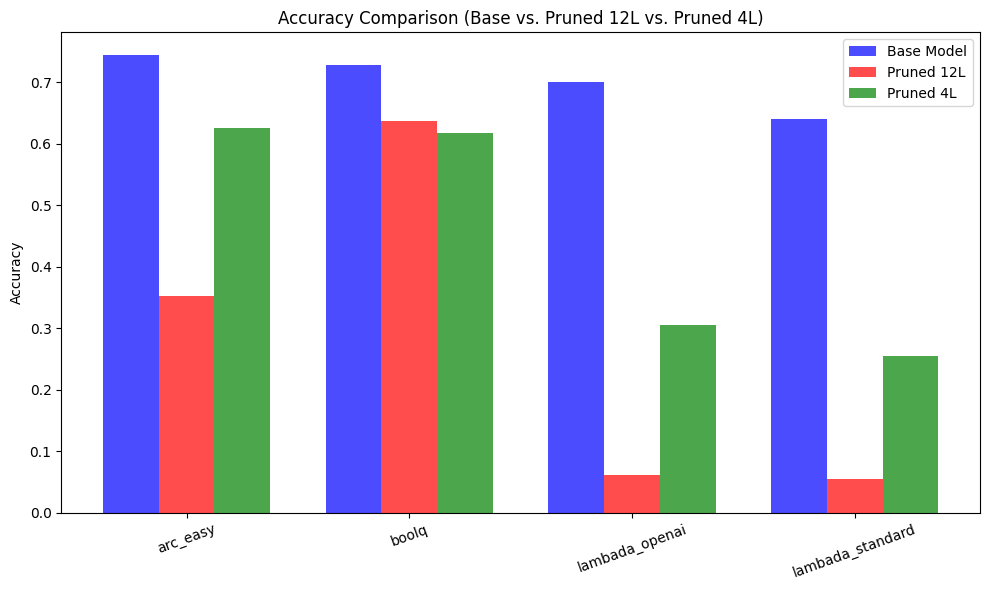

In [57]:
# Call visualization function
visualize_metrics(metrics_base, metrics_pruned_12l, metrics_pruned_4l)